# NSSP project 1

In [1]:
%gui wx
import sys
import os

#####################
# Import of utils.py functions
#####################
# Required to get utils.py and access its functions
notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist, interactive_MCQ

####################
# DIPY_HOME should be set prior to import of dipy to make sure all downloads point to the right folder
####################
os.environ["DIPY_HOME"] = "/home/jovyan/data/Projet1_NSSP/NSSP"


#############################
# Loading fsl and freesurfer within Neurodesk
# You can find the list of available other modules by clicking on the "Softwares" tab on the left
#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

####################
# Setup FSL path
####################
loadFSL()

###################
# Load all relevant libraries for the lab
##################
import fsl.wrappers
from fsl.wrappers import fslmaths

import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri

import mne
import mne_nirs
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob

import ants

import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report


# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm


# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt

# General purpose imports to handle paths, files etc
import glob
import pandas as pd
import numpy as np
import json
import subprocess

In [2]:
################
# Start FSLeyes 
################
fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()

12:14:31: Debug: Adding duplicate image handler for 'Windows bitmap file'
12:14:31: Debug: Adding duplicate animation handler for '1' type
12:14:31: Debug: Adding duplicate animation handler for '2' type
12:14:31: Debug: Adding duplicate image handler for 'Windows bitmap file'
12:14:31: Debug: Adding duplicate animation handler for '1' type
12:14:31: Debug: Adding duplicate animation handler for '2' type

(ipykernel_launcher.py:1152): Gtk-CRITICAL **: 12:14:31.726: gtk_window_resize: assertion 'height > 0' failed


In [3]:
#download the dataset

#"https://openneuro.org/datasets/ds000171/versions/00001"
dataset_id= 'ds000171'
subject = 'control01'

#path to save
sample_path = "/home/jovyan/data/Projet1_NSSP/NSSP"
mkdir_no_exist(sample_path)
bids_root = op.join(sample_path, dataset_id)
deriv_root = op.join(bids_root, 'derivatives')
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')

mkdir_no_exist(bids_root)

subject_dir = 'sub-{}'.format(subject)

###################
# Create folders relevant for preprocessing.
# In BIDs, ANYTHING we modify must go in the derivatives folder, to keep original files clean in case we make a mistake.
subprocess.run(["openneuro-py", "download", "--dataset", dataset_id, # Openneuro has for each dataset a unique identifier
                "--target-dir", bids_root,  # The path where we want to save our data. You should save your data under /home/jovyan/Data/[your dataset ID] to be 100% fool-proof
                "--include", op.join(subject_dir, '*'),# We are asking to get all files within the subject_dir folder by using the wildcard *
               ], check=True)
###################
mkdir_no_exist(op.join(bids_root, 'derivatives'))
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')
mkdir_no_exist(preproc_root)
mkdir_no_exist(op.join(preproc_root, 'sub-control01'))
mkdir_no_exist(op.join(preproc_root, 'sub-control01', 'anat'))
mkdir_no_exist(op.join(preproc_root, 'sub-control01', 'func'))
mkdir_no_exist(op.join(preproc_root, 'sub-control01', 'fmap'))


👋 Hello! This is openneuro-py 2024.2.0. Great to see you! 🤗

   👉 Please report problems 🤯 and bugs 🪲 at
      https://github.com/hoechenberger/openneuro-py/issues

🌍 Preparing to download ds000171 …


╭───────────────────── Traceback (most recent call last) ──────────────────────╮
│ /opt/conda/lib/python3.11/site-packages/openneuro/_cli.py:64 in download_cli │
│                                                                              │
│    61 │   ] = 5,                                                             │
│    62 ) -> None:                                                             │
│    63 │   """Download datasets from OpenNeuro."""                            │
│ ❱  64 │   download(                                                          │
│    65 │   │   dataset=dataset,                                               │
│    66 │   │   tag=tag,                                                       │
│    67 │   │   target_dir=target_dir,                                         │
│                                                                              │
│ ╭───────────────────────────────── locals ─────────────────────────────────╮ │
│ │                  dataset

CalledProcessError: Command '['openneuro-py', 'download', '--dataset', 'ds000171', '--target-dir', '/home/jovyan/data/Projet1_NSSP/NSSP/ds000171', '--include', 'sub-control01/*']' returned non-zero exit status 1.

In [4]:
# explore the dataset folder
print_dir_tree(bids_root,5)

|ds000171/
|--- CHANGES
|--- README
|--- dataset_description.json
|--- participants.tsv
|--- .ipynb_checkpoints/
|------ CHANGES-checkpoint
|------ dataset_description-checkpoint.json
|------ participants-checkpoint.tsv
|--- derivatives/
|------ preprocessed_data/
|--------- .ipynb_checkpoints/
|--------- sub-control01/
|------------ anat/
|--------------- sub-control01_T1w.nii.gz
|--------------- sub-control01_T1w_fast_mixeltype.nii.gz
|--------------- sub-control01_T1w_fast_pve_0.nii.gz
|--------------- sub-control01_T1w_fast_pve_1.nii.gz
|--------------- sub-control01_T1w_fast_pve_2.nii.gz
|--------------- sub-control01_T1w_fast_pveseg.nii.gz
|--------------- sub-control01_T1w_fast_seg.nii.gz
|--------------- sub-control01_T1w_mask.nii.gz
|--------------- sub-control01_T1w_mni.nii.gz
|--------------- sub-control01_T1w_mni_SyN.nii.gz
|------------ fmap/
|------------ func/
|--------------- sub-control01_task-music_concat_bold_bbr_smoothed-6mm.nii.gz
|--------------- sub-control01_tas

# Anatomical preprocessing

In [5]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(bids_root, 'sub-control01', 'anat', 'sub-control01_T1w.nii.gz'))


(ipykernel_launcher.py:1152): Gdk-WARNING **: 12:14:50.551: gdkdrawable-x11.c:952 drawable is not a pixmap or window


## 1.1 Skull stripping

In [6]:
def get_skull_stripped_anatomical(bids_root, preproc_root, subject_id, robust=True):
    """
    Parameters
    ----------
    bids_root: string
        The root of the BIDS directory
    preproc_root: string
        The root of the preprocessed data, where the result of the brain extraction will be saved.
    subject_id: string
        Subject ID, the subject on which brain extraction should be conducted.
    robust: bool
        Whether to conduct robust center estimation with BET or not. Default is False.
    """
    subject = 'sub-{}'.format(subject_id)
    anatomical_path = op.join(bids_root, subject, 'anat', 'sub-{}_T1w.nii.gz'.format(subject_id))
    betted_brain_path = op.join(preproc_root, subject, 'anat', 'sub-{}_T1w'.format(subject_id))
    os.system('bet {} {} -m {}'.format(anatomical_path, betted_brain_path, '-R' if robust else ''))
    print("Done with BET.")

resulting_mask_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w_mask')
get_skull_stripped_anatomical(bids_root, preproc_root, "control01")

Done with BET.


In [7]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(bids_root, 'sub-control01', 'anat', 'sub-control01_T1w.nii.gz'))
fsleyesDisplay.load(resulting_mask_path)

In [8]:
def apply_fsl_math_approach(img_path, mask_path, masked_img_path):
    os.system('fslmaths {} -mas {} {}'.format(img_path, mask_path, masked_img_path))
    
anatomical_path = op.join(bids_root, 'sub-control01', 'anat', 'sub-control01_T1w.nii.gz') # The original brain
betted_brain_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w.nii.gz') # The brain without skull is in the derivatives folder
resulting_mask_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w_mask.nii.gz') # The mask to use

apply_fsl_math_approach(anatomical_path, resulting_mask_path, betted_brain_path)

In [9]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(betted_brain_path)

##  1.2 Tissue Segmentation

In [10]:
anatomical_path = op.join(bids_root, 'sub-control01', 'anat', 'sub-control01_T1w.nii.gz')
bet_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w')

fast_target = bet_path 

[os.remove(f) for f in glob.glob(op.join(preproc_root, 'sub-control01', 'anat', '*fast*'))] 
segmentation_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w_fast')
fast(imgs=[fast_target], out=segmentation_path, n_classes=3)

{}

## 1.3 Anatomical Normalization

In [11]:
from fsl.wrappers import flirt

subject_id = 'control01'
subject_anatomical = op.join(preproc_root, 'sub-{}'.format(subject_id), 'anat', 'sub-control01_T1w')
mni_template = op.expandvars(op.join('$FSLDIR', 'data', 'standard', 'MNI152_T1_1mm_brain'))

target = subject_anatomical
reference = mni_template

#FLIRT Linear
result = op.join(preproc_root, 'sub-{}'.format(subject_id), 'anat', 'sub-{}_T1w_mni'.format(subject_id))
flirt(target, reference, out=result)

#FNIRT non-linear
moving_image = ants.image_read(target + '.nii.gz')
fixed_image = ants.image_read(reference + '.nii.gz')

transformation = ants.registration(fixed=fixed_image, moving=moving_image, type_of_transform = 'SyN' )
warpedImage = ants.apply_transforms(fixed=fixed_image, moving=moving_image, transformlist=transformation['fwdtransforms'])
resultAnts = op.join(preproc_root, 'sub-{}'.format(subject_id), 'anat', 'sub-{}_T1w_mni_SyN.nii.gz'.format(subject_id))
ants.image_write(warpedImage, resultAnts)


Final result: 
0.003348 0.005721 -1.116064 204.794610 
-0.933350 0.500887 0.005750 178.784833 
0.501418 1.048657 -0.003251 -149.700516 
0.000000 0.000000 0.000000 1.000000 



In [12]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(reference)
fsleyesDisplay.load(result)
fsleyesDisplay.load(resultAnts)

# FMRI preprocessing

## 1.1 Volume removal (if necessary)

In [13]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(bids_root, 'sub-control01', 'func', 'sub-control01_task-music_run-1_bold.nii.gz'))

Text(0, 0.5, 'Mean voxel intensity')

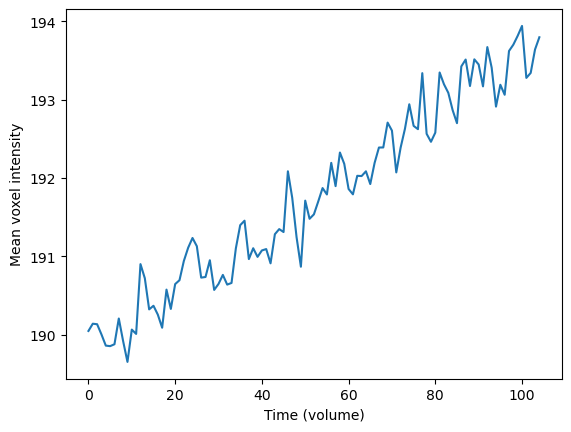

In [14]:
import matplotlib.pyplot as plt
import nibabel as nib

plt.plot(nib.load(op.join(bids_root, 'sub-control01','func', 'sub-control01_task-music_run-1_bold.nii.gz')).get_fdata().mean(axis=(0,1,2)))
plt.xlabel('Time (volume)')
plt.ylabel('Mean voxel intensity')
#we see no need of volume removal here

## 1.2 Motion Correction 

In [15]:
from fsl.wrappers import mcflirt

path_original_data = os.path.join(bids_root, 'sub-control01', 'func', 'sub-control01_task-music_run-1_bold')
path_moco_data = os.path.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_run-1_bold_moco')
mcflirt(infile=path_original_data,o=path_moco_data, plots=True, report=True, dof=6, mats=True)

path_original_data2 = os.path.join(bids_root, 'sub-control01', 'func', 'sub-control01_task-music_run-2_bold')
path_moco_data2 = os.path.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_run-2_bold_moco')
mcflirt(infile=path_original_data2,o=path_moco_data2, plots=True, report=True, dof=6, mats=True)

path_original_data3 = os.path.join(bids_root, 'sub-control01', 'func', 'sub-control01_task-music_run-3_bold')
path_moco_data3 = os.path.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_run-3_bold_moco')
mcflirt(infile=path_original_data3,o=path_moco_data3, plots=True, report=True, dof=6, mats=True)

Processed data will be saved as /home/jovyan/data/Projet1_NSSP/NSSP/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-1_bold_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [52] to 8 mm pixels
Registering volumes ... [53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96][97][98][99][100][101][102][103][104][51][50][49][48][47][46][45][44][43][42][41][40][39][38][37][36][35][34][33][32][31][30][29][28][27][26][25][24][23][22][21][20][19][18][17][16][15][14][13][12][11][10][9][8][7][6][5][4][3][2][1][0]
second iteration - drop to 4mm scaling
Rescaling reference volume [52] to 4 mm pixels
Registering volumes ... [53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][8

refnum = 52
Original_refvol = -1


Registering volumes ... [53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96][97][98][99][100][101][102][103][104][51][50][49][48][47][46][45][44][43][42][41][40][39][38][37][36][35][34][33][32][31][30][29][28][27][26][25][24][23][22][21][20][19][18][17][16][15][14][13][12][11][10][9][8][7][6][5][4][3][2][1][0]
Saving motion corrected time series... 
Processed data will be saved as /home/jovyan/data/Projet1_NSSP/NSSP/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-2_bold_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [52] to 8 mm pixels
Registering volumes ... [53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96]

refnum = 52
Original_refvol = -1


Registering volumes ... [53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96][97][98][99][100][101][102][103][104][51][50][49][48][47][46][45][44][43][42][41][40][39][38][37][36][35][34][33][32][31][30][29][28][27][26][25][24][23][22][21][20][19][18][17][16][15][14][13][12][11][10][9][8][7][6][5][4][3][2][1][0]
Saving motion corrected time series... 
Processed data will be saved as /home/jovyan/data/Projet1_NSSP/NSSP/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-3_bold_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [52] to 8 mm pixels
Registering volumes ... [53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96]

refnum = 52
Original_refvol = -1


Registering volumes ... [53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96][97][98][99][100][101][102][103][104][51][50][49][48][47][46][45][44][43][42][41][40][39][38][37][36][35][34][33][32][31][30][29][28][27][26][25][24][23][22][21][20][19][18][17][16][15][14][13][12][11][10][9][8][7][6][5][4][3][2][1][0]
Saving motion corrected time series... 


{}

In [16]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(path_original_data2)
fsleyesDisplay.load(path_moco_data2)

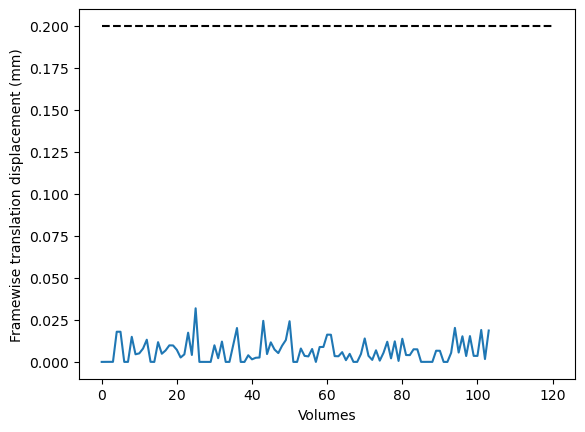

In [17]:
#inspect the translation on X 
def load_mot_params_fsl_6_dof(path):
    return pd.read_csv(path, sep='  ', header=None, 
            engine='python', names=['Rotation x', 'Rotation y', 'Rotation z','Translation x', 'Translation y', 'Translation z'])

mot_params = load_mot_params_fsl_6_dof(op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_run-1_bold_moco.par'))

trans_x = mot_params["Translation x"]
# Now, we want a 0.2mm with respect to previous frame:
disp_x = np.diff(trans_x)
# Lastly, we can ask for displacements (in absolute value) above 0.2mm and plot it to be clear:
threshold=0.2
plt.plot(np.abs(disp_x))
plt.hlines(threshold, 0, 120,colors='black', linestyles='dashed', label='FD threshold')
plt.xlabel("Volumes")
plt.ylabel("Framewise translation displacement (mm)")
plt.show()

# There are basically (if looking only along X translation) no frame displacement above 0.2mm!

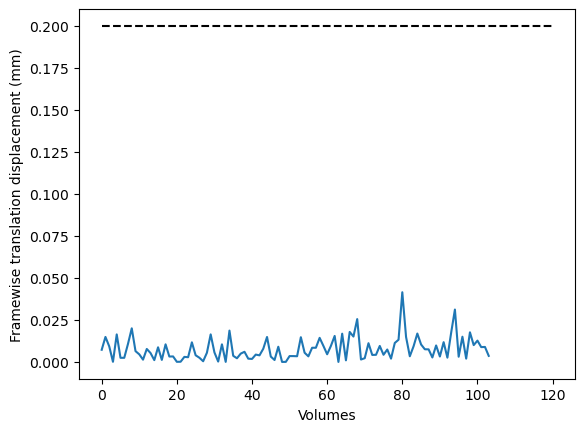

In [18]:
#pour run 2
mot_params2 = load_mot_params_fsl_6_dof(op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_run-2_bold_moco.par'))

trans_x2 = mot_params2["Translation x"]
# Now, we want a 0.2mm with respect to previous frame:
disp_x2 = np.diff(trans_x2)
# Lastly, we can ask for displacements (in absolute value) above 0.2mm and plot it to be clear:
threshold=0.2
plt.plot(np.abs(disp_x2))
plt.hlines(threshold, 0, 120,colors='black', linestyles='dashed', label='FD threshold')
plt.xlabel("Volumes")
plt.ylabel("Framewise translation displacement (mm)")
plt.show()

# There are basically (if looking only along X translation) no frame displacement above 0.2mm!

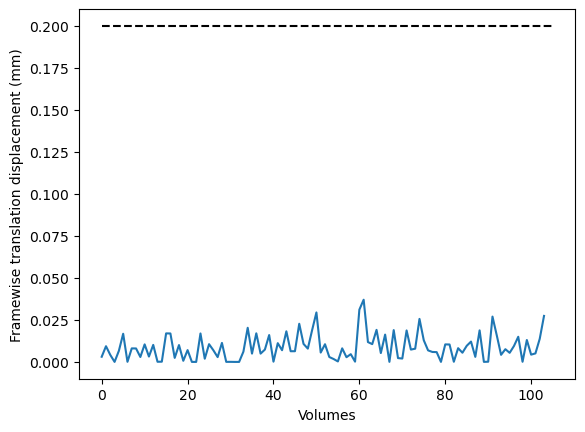

In [19]:
#pour run 3
mot_params3 = load_mot_params_fsl_6_dof(op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_run-3_bold_moco.par'))

trans_x3 = mot_params3["Translation x"]
# Now, we want a 0.2mm with respect to previous frame:
disp_x3 = np.diff(trans_x3)
# Lastly, we can ask for displacements (in absolute value) above 0.2mm and plot it to be clear:
threshold=0.2
plt.plot(np.abs(disp_x3))
plt.hlines(threshold, 0, 105,colors='black', linestyles='dashed', label='FD threshold')
plt.xlabel("Volumes")
plt.ylabel("Framewise translation displacement (mm)")
plt.show()

# There are basically (if looking only along X translation) no frame displacement above 0.2mm!

In [20]:
def compute_FD_power(mot_params):
    framewise_diff = mot_params.diff().iloc[1:]

    rot_params = framewise_diff[['Rotation x', 'Rotation y', 'Rotation z']]
    # Estimating displacement on a 50mm radius sphere
    converted_rots = rot_params*50
    trans_params = framewise_diff[['Translation x', 'Translation y', 'Translation z']]
    fd = converted_rots.abs().sum(axis=1) + trans_params.abs().sum(axis=1)
    return fd

fd = compute_FD_power(mot_params).to_numpy()
fd2 = compute_FD_power(mot_params2).to_numpy()
fd3 = compute_FD_power(mot_params3).to_numpy()

In [21]:
threshold = np.quantile(fd,0.75) + 1.5*(np.quantile(fd,0.75) - np.quantile(fd,0.25))

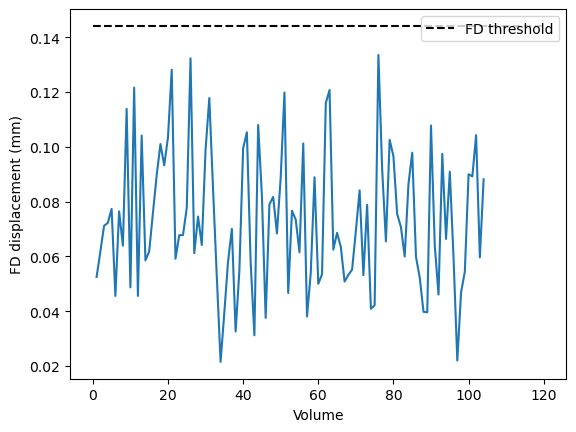

In [22]:
plt.plot(list(range(1, fd.size+1)), fd)
plt.xlabel('Volume')
plt.ylabel('FD displacement (mm)')
plt.hlines(threshold, 0, 120,colors='black', linestyles='dashed', label='FD threshold')
plt.legend()
plt.show()
#no volumes above threshold

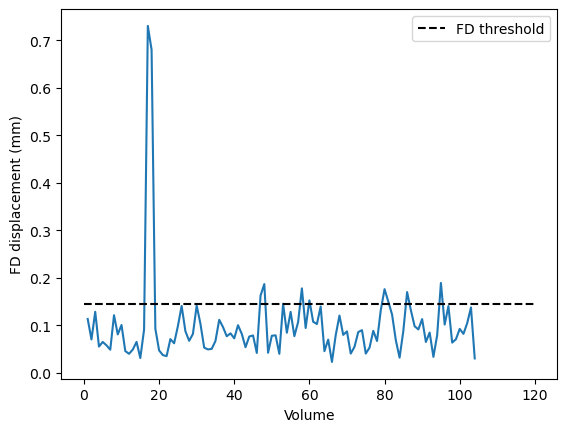

array([17, 18, 47, 48, 53, 58, 60, 80, 81, 86, 95])

In [23]:
#%matplotlib inline
plt.plot(list(range(1, fd2.size+1)), fd2)
plt.xlabel('Volume')
plt.ylabel('FD displacement (mm)')
plt.hlines(threshold, 0, 120,colors='black', linestyles='dashed', label='FD threshold')
plt.legend()
plt.show()

np.where(fd2 > threshold)[0] + 1 #volumes above threshold that were eliminated in the motion correction process

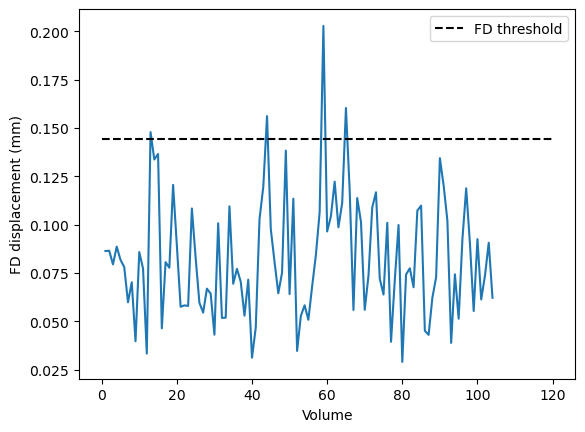

array([13, 44, 59, 65])

In [24]:
#%matplotlib inline
plt.plot(list(range(1, fd3.size+1)), fd3)
plt.xlabel('Volume')
plt.ylabel('FD displacement (mm)')
plt.hlines(threshold, 0, 120,colors='black', linestyles='dashed', label='FD threshold')
plt.legend()
plt.show()

np.where(fd3 > threshold)[0] + 1 #volumes above threshold that were eliminated in the motion correction process

## 1.3 Coregistration of functional to anatomical

In [25]:
subprocess.run(['fslroi'])


Usage: fslroi <input> <output> <xmin> <xsize> <ymin> <ysize> <zmin> <zsize>
       fslroi <input> <output> <tmin> <tsize>

       fslroi <input> <output> <xmin> <xsize> <ymin> <ysize> <zmin> <zsize> <tmin> <tsize>
Note: indexing (in both time and space) starts with 0 not 1! Inputting -1 for a size will set it to the full image extent for that dimension.


CompletedProcess(args=['fslroi'], returncode=1)

In [26]:
from fsl.wrappers import epi_reg

# We use the motion corrected EPI
epi_target = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_run-1_bold_moco')

whole_t1 = op.join(bids_root, 'sub-control01', 'anat', 'sub-control01_T1w')
skull_stripped_t1 = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w')

output_path = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_run-1_bold_bbr')
ref_vol_name =  op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_run-1_bold_moco_vol_middle')

white_matter_segmentation = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w_fast_pve_2.nii.gz') 

fslroi(epi_target, ref_vol_name, str(52), str(1))
subprocess.run(['epi_reg','--epi={}'.format(ref_vol_name), '--t1={}'.format(whole_t1), '--t1brain={}'.format(skull_stripped_t1), 
                '--out={}'.format(output_path),
               '--wmseg={}'.format(white_matter_segmentation)])

FLIRT pre-alignment
Running BBR
0.297505 0.999221 -0.039225 -0.004442 0.000000 0.039273 0.999164 0.011330 0.000000 0.003994 -0.011495 0.999926 0.000000 -5.421773 9.639053 -0.991901 1.000000 


CompletedProcess(args=['epi_reg', '--epi=/home/jovyan/data/Projet1_NSSP/NSSP/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-1_bold_moco_vol_middle', '--t1=/home/jovyan/data/Projet1_NSSP/NSSP/ds000171/sub-control01/anat/sub-control01_T1w', '--t1brain=/home/jovyan/data/Projet1_NSSP/NSSP/ds000171/derivatives/preprocessed_data/sub-control01/anat/sub-control01_T1w', '--out=/home/jovyan/data/Projet1_NSSP/NSSP/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-1_bold_bbr', '--wmseg=/home/jovyan/data/Projet1_NSSP/NSSP/ds000171/derivatives/preprocessed_data/sub-control01/anat/sub-control01_T1w_fast_pve_2.nii.gz'], returncode=0)

In [27]:
# same for run 2
epi_target2 = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_run-2_bold_moco')

output_path2 = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_run-2_bold_bbr')
ref_vol_name2 =  op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_run-2_bold_moco_vol_middle')

fslroi(epi_target2, ref_vol_name2, str(52), str(1))
subprocess.run(['epi_reg','--epi={}'.format(ref_vol_name2), '--t1={}'.format(whole_t1), '--t1brain={}'.format(skull_stripped_t1), 
                '--out={}'.format(output_path2),
               '--wmseg={}'.format(white_matter_segmentation)])
#same for run 3
epi_target3 = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_run-3_bold_moco')

output_path3 = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_run-3_bold_bbr')
ref_vol_name3 =  op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_run-3_bold_moco_vol_middle')

fslroi(epi_target3, ref_vol_name3, str(52), str(1))
subprocess.run(['epi_reg','--epi={}'.format(ref_vol_name3), '--t1={}'.format(whole_t1), '--t1brain={}'.format(skull_stripped_t1), 
                '--out={}'.format(output_path3),
               '--wmseg={}'.format(white_matter_segmentation)])

FLIRT pre-alignment
Running BBR
0.290740 0.999457 -0.032911 -0.001616 0.000000 0.032918 0.999448 0.004528 0.000000 0.001466 -0.004579 0.999988 0.000000 -4.425919 7.800308 -0.536589 1.000000 
FLIRT pre-alignment
Running BBR
0.294588 0.999655 -0.025994 -0.003657 0.000000 0.026010 0.999652 0.004334 0.000000 0.003543 -0.004428 0.999984 0.000000 -3.743286 6.820484 -0.308608 1.000000 


CompletedProcess(args=['epi_reg', '--epi=/home/jovyan/data/Projet1_NSSP/NSSP/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-3_bold_moco_vol_middle', '--t1=/home/jovyan/data/Projet1_NSSP/NSSP/ds000171/sub-control01/anat/sub-control01_T1w', '--t1brain=/home/jovyan/data/Projet1_NSSP/NSSP/ds000171/derivatives/preprocessed_data/sub-control01/anat/sub-control01_T1w', '--out=/home/jovyan/data/Projet1_NSSP/NSSP/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-3_bold_bbr', '--wmseg=/home/jovyan/data/Projet1_NSSP/NSSP/ds000171/derivatives/preprocessed_data/sub-control01/anat/sub-control01_T1w_fast_pve_2.nii.gz'], returncode=0)

In [28]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(skull_stripped_t1)
fsleyesDisplay.load(output_path)
fsleyesDisplay.load(output_path2)
fsleyesDisplay.load(output_path3)

In [29]:
def cleanup_epi_reg(path_to_clean):
    patterns = ['*_fast_*', '*_fieldmap*']
    for p in patterns:
        files = glob.glob(op.join(path_to_clean, p))
        for f in files:
            os.remove(f)

cleanup_epi_reg(op.join(preproc_root, 'sub-control01', 'func'))

## 1.4 Smoothing

In [30]:
cmd = 'fslmaths {} -s {} {}_smoothed-6mm'.format(output_path, 6/2.3548, output_path)
subprocess.run(['fslmaths',output_path, '-s', str(6/2.3548), '{}_smoothed-6mm'.format(output_path)])

cmd = 'fslmaths {} -s {} {}_smoothed-6mm'.format(output_path2, 6/2.3548, output_path2)
subprocess.run(['fslmaths',output_path2, '-s', str(6/2.3548), '{}_smoothed-6mm'.format(output_path2)])

cmd = 'fslmaths {} -s {} {}_smoothed-6mm'.format(output_path3, 6/2.3548, output_path3)
subprocess.run(['fslmaths',output_path3, '-s', str(6/2.3548), '{}_smoothed-6mm'.format(output_path3)])

CompletedProcess(args=['fslmaths', '/home/jovyan/data/Projet1_NSSP/NSSP/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-3_bold_bbr', '-s', '2.547987090198743', '/home/jovyan/data/Projet1_NSSP/NSSP/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-3_bold_bbr_smoothed-6mm'], returncode=0)

In [31]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(output_path + '_smoothed-6mm')
fsleyesDisplay.load(output_path2 + '_smoothed-6mm')
fsleyesDisplay.load(output_path3 + '_smoothed-6mm')

# GLM

## 1.1 Concatenate all 3 events.tsv file into a single 1

In [32]:
func_path = op.join(bids_root, 'sub-control01', 'func')
pd.read_csv(op.join(func_path, 'sub-control01_task-music_run-1_events.tsv'), sep='\t')

,onset,duration,trial_type
0,0.0,33.0,tones
1,33.0,3.0,response
2,36.0,31.5,negative_music
3,67.5,3.0,response
4,70.5,31.5,tones
5,102.0,3.0,response
6,105.0,31.5,positive_music
7,136.5,3.0,response
8,139.5,31.5,tones
9,171.0,3.0,response


In [33]:
pd.read_csv(op.join(func_path, 'sub-control01_task-music_run-2_events.tsv'), sep='\t')

,onset,duration,trial_type
0,0.0,33.0,tones
1,33.0,3.0,response
2,36.0,31.5,positive_music
3,67.5,3.0,response
4,70.5,31.5,tones
5,102.0,3.0,response
6,105.0,31.5,negative_music
7,136.5,3.0,response
8,139.5,31.5,tones
9,171.0,3.0,response


In [34]:
pd.read_csv(op.join(func_path, 'sub-control01_task-music_run-3_events.tsv'), sep='\t')

,onset,duration,trial_type
0,0.0,33.0,tones
1,33.0,3.0,response
2,36.0,31.5,negative_music
3,67.5,3.0,response
4,70.5,31.5,tones
5,102.0,3.0,response
6,105.0,31.5,positive_music
7,136.5,3.0,response
8,139.5,31.5,tones
9,171.0,3.0,response


In [35]:
# Load the event data from each run
events1 = pd.read_csv(op.join(func_path, 'sub-control01_task-music_run-1_events.tsv'), sep='\t')
events2 = pd.read_csv(op.join(func_path, 'sub-control01_task-music_run-2_events.tsv'), sep='\t')
events3 = pd.read_csv(op.join(func_path, 'sub-control01_task-music_run-3_events.tsv'), sep='\t')

#Adjust onset time for run 2 and 3
run1_duration = events1['onset'].max() + events1['duration'].iloc[-1]
run2_duration = events2['onset'].max() + events2['duration'].iloc[-1]

events2['onset'] += run1_duration
events3['onset'] += (run1_duration + run2_duration)

# Concatenate the tables
combined_events = pd.concat([events1, events2, events3], ignore_index=True)

# Save the combined result to a new file or display it
combined_events.to_csv(op.join(func_path, 'combined_events.tsv'), sep='\t', index=False)
combined_events

,onset,duration,trial_type
0,0.0,33.0,tones
1,33.0,3.0,response
2,36.0,31.5,negative_music
3,67.5,3.0,response
4,70.5,31.5,tones
5,102.0,3.0,response
6,105.0,31.5,positive_music
7,136.5,3.0,response
8,139.5,31.5,tones
9,171.0,3.0,response


## 1.2 Concatenate all preprocessed smoothed.nii.gz files into a single 1

In [36]:
from nilearn.image import concat_imgs
import os.path as op

# concatenation of FMRI preprocessed data
preprocessed_files = [
    op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_run-1_bold_bbr_smoothed-6mm.nii.gz'),
    op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_run-2_bold_bbr_smoothed-6mm.nii.gz'),
    op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_run-3_bold_bbr_smoothed-6mm.nii.gz')
]

# Concatenate the 4D fMRI images
fmri_img = concat_imgs(preprocessed_files)
output_path = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concat_bold_bbr_smoothed-6mm.nii.gz')
fmri_img.to_filename(output_path)

## 1.3 Design Matrix

In [37]:
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel

# Specify what sort of GLM we want (nature of the noise, repetition time of the data and other parameters)
fmri_glm = FirstLevelModel(t_r=3,   #found in task-music_bold.json file 
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm', 
                           drift_model=None, 
                           high_pass=.01)

# Fit the model to our design and data
fmri_glm = fmri_glm.fit(fmri_img, combined_events)

/opt/conda/lib/python3.11/site-packages/nilearn/glm/_utils.py:176: RuntimeWarning: divide by zero encountered in scalar divide
  cond = smax / smin
/opt/conda/lib/python3.11/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


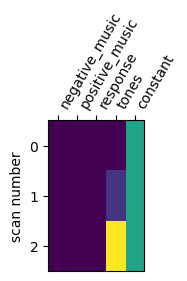

In [38]:
from nilearn.plotting import plot_design_matrix
plot_design_matrix(fmri_glm.design_matrices_[0])
plt.show()

In [42]:
import nibabel as nib

# Load the NIfTI file
file_path = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concat_bold_bbr_smoothed-6mm.nii.gz')
fmri_img = nib.load(file_path)

# Extract shape and TR information
fmri_img_shape = fmri_img.shape
fmri_img_header = fmri_img.header
tr_value = fmri_img_header.get_zooms()[3] if len(fmri_img_header.get_zooms()) > 3 else None

print(f"Shape of the fMRI image: {fmri_img_shape}")
print(f"TR value: {tr_value} seconds")

Shape of the fMRI image: (256, 256, 176, 3)
TR value: 3.0 seconds
